# Product Recognition on Store Shelves

#### Project Work in Image Processing and Computer Vision - Master in Artificial Intelligence
###### Chiara Malizia - 0000954488


### Task A - Multiple Product Detection

#### Develop an object detection system to identify single instance of products given: one reference image for each item and a scene image

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

In [2]:
#auxiliar functions 

def showImage(title, image):
    plt.title(title)
    plt.imshow(image[:,:,::-1])
    plt.show()
    
def drawKeypoints(scene, kp):
    kp_visualization = cv2.drawKeypoints(scene, kp, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) #flag useful to show scale and orientation of keypoints
    return kp_visualization   

def saveModel(productId):
    model = cv2.imread('images/models/%d.jpg' %productId, cv2.IMREAD_COLOR)
    #Find descriptors and detectors with SIFT
    kp, des = sift.detectAndCompute(model, None)
    #showImage("Model %d" %productId, drawKeypoints(model, kp))
    return (model, productId, kp, des, model.shape)



In [3]:
PRODUCT_IMAGES =  [0, 1, 11, 19, 24, 26, 25]

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
print("----- Loading models -----" )
# Save models
models = [saveModel(p) for p in PRODUCT_IMAGES]
print("----- Models loaded -----")

----- Loading models -----
----- Models loaded -----



----- Analysis of scene e1 -----
Product 0 found: [position (162,214), width 310px, height 433px]
Product 1 found: [position (444,165), width 295px, height 384px]


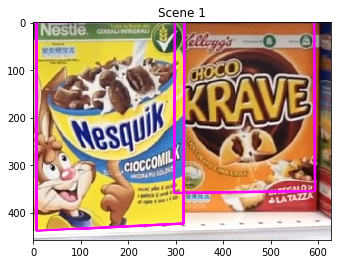


-------------------------------------------------------------------

----- Analysis of scene e2 -----
Product 24 found: [position (167,219), width 334px, height 489px]
Product 26 found: [position (538,218), width 333px, height 486px]
Product 25 found: [position (872,273), width 337px, height 525px]


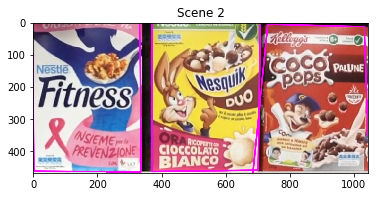


-------------------------------------------------------------------

----- Analysis of scene e3 -----
Product 0 found: [position (170,236), width 324px, height 440px]
Product 1 found: [position (476,185), width 298px, height 390px]


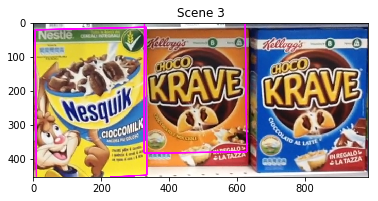


-------------------------------------------------------------------

----- Analysis of scene e4 -----
Product 0 found: [position (158,739), width 324px, height 440px]
Product 1 found: [position (464,688), width 299px, height 389px]
Product 26 found: [position (205,195), width 341px, height 493px]
Product 25 found: [position (553,256), width 350px, height 542px]


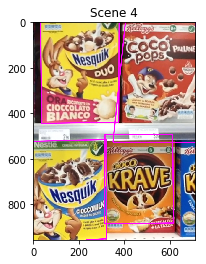


-------------------------------------------------------------------

----- Analysis of scene e5 -----
Product 19 found: [position (503,190), width 295px, height 384px]
Product 25 found: [position (160,227), width 320px, height 445px]


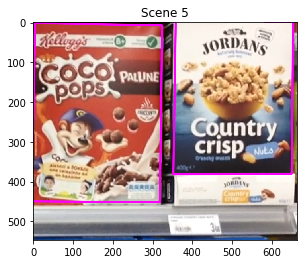


-------------------------------------------------------------------


In [4]:
# FLANN matcher parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks = 50)

#Thresholds
MIN_MATCH_COUNT = 250
LOWE_RATIO_THRESHOLD = 0.8
DISTANCE_THRESHOLD = 200


# Initiate and set FLANN matcher 
flann = cv2.FlannBasedMatcher(index_params, search_params)

for scene in range(1, 6): 
    
    print("\n----- Analysis of scene e%d -----" %scene)
    target= cv2.imread('images/scenes/e%d.png' %scene, cv2.IMREAD_COLOR)
    
    # Find keypoints and descriptors with SIFT 
    kp_target, des_target = sift.detectAndCompute(target, None)
    #showImage("Scene %d" %scene, drawKeypoints(target, kp_target))
    
    barycenters = []
    
    for model, prod_id, kp_model, des_model, model_shape in models:
        
        # Match and find the 2 closest elements for each query descriptor
        matches = flann.knnMatch(des_model, des_target, k=2)
        
        # Store those matches that are good enough according to Lowe's ratio test
        good_matches=[m for m, n in matches if m.distance< LOWE_RATIO_THRESHOLD * n.distance]
        
        # Check if there are enough matches
        if len(good_matches)>= MIN_MATCH_COUNT:
            
            # Find homography using RANSAC
            source_pts = np.float32([ kp_model[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2) #pts forse è points
            destination_pts = np.float32([ kp_target[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
            M, mask = cv2.findHomography( source_pts, destination_pts, cv2.RANSAC, 5.0 ) #M is thehomography and mask is a mask for the discarded points
            
            # Mask of discarded point used in visualization
            matchesMask = mask.ravel().tolist()
            
            # Corners of the model image
            h,w,d = model_shape
            pts = np.float32([ [0,0], [0,h-1], [w-1,h-1], [w-1,0] ]).reshape(-1,1,2)
            
            # Project the corners of the model image into the target image
            dst = cv2.perspectiveTransform(pts,M) 
                      
            # Compute barycenter, width and height
            x_corners = [corner[0] for corner in dst[:,0]]
            y_corners = [corner[1] for corner in dst[:,0]]
            barycenter = (sum(x_corners))/4, sum(y_corners)/4
            width = (x_corners[3] - x_corners[0] + x_corners[2]- x_corners[1]) / 2
            height = (y_corners[1] - y_corners[0] + y_corners[2] - y_corners[3]) / 2
            
            # Check whether two instances are overlapped
            if True in [math.sqrt((barycenter[0] - b[0])**2 + (barycenter[1] - b[1])**2) <= DISTANCE_THRESHOLD for b in barycenters]:
                    #print("Product %d ignored: overlapping" %prod_id)
                    pass
                
            #Check if the instance found is not a point 
            if height<1 or width<1:
                pass
            
            else:
                
                # Draw the bounding box
                target = cv2.polylines(target, [np.int32(dst)], True, (255,0,255), 3, cv2.LINE_AA)
                
                # Store current barycenter for next tests
                barycenters.append(barycenter)
                
                ## Draw the matches
                #model = cv2.imread('images/models/%d.jpg' %prod_id, cv2.IMREAD_COLOR)
                #draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                #                  singlePointColor = None, # not draw keypoints only matching lines
                #                   matchesMask = matchesMask, # draw only inliers
                #                   flags = 2) # not draw keypoints only lines
                #img3 = cv2.drawMatches(model, kp_model,target,kp_target,good_matches,None,**draw_params)
                #plt.imshow(img3[:,:,::-1])
                #plt.show()
            
                print("Product %d found: [position (%d,%d), width %dpx, height %dpx]" % (prod_id, barycenter[0], barycenter[1], width, height))
            
        #else:
         #   print("Product %d not found" %prod_id )
          #  matchesMask = None
    showImage("Scene %d" % scene, target)
            
    print("\n-------------------------------------------------------------------")
   

### Task B - Multiple Instance Detection

#### In addition to what achieved at step A, the system should now be able to detect multiple instance of the same product. 

In [5]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from itertools import cycle

In [6]:
#auxiliar functions 
  
def saveModel(productId):
    model = cv2.imread('images/models/%d.jpg' % productId, cv2.IMREAD_COLOR)
    # Compute reference point
    ref = (int(model.shape[1] / 2), int(model.shape[0] / 2))
    # Find descriptors and detectors with SIFT
    kp, des = sift.detectAndCompute(model, None)
    # Compute joining vectors
    join = [np.array([[ref[0] - point.pt[0]], [ref[1] - point.pt[1]]]) for point in kp]
    return (model, productId, kp, des, model.shape, join)


def is_rectangle(x_corners, y_corners, height, width): 
    # Check if the two diagonals have the same length
    diag1 = math.sqrt(((y_corners[1]-y_corners[0])**2) + ((x_corners[2]-x_corners[1])**2))
    diag2 = math.sqrt(((y_corners[2]-y_corners[3])**2) + ((x_corners[3]-x_corners[0])**2))
    diag_max = max(diag1,diag2)
    diag_min = min(diag1,diag2)
    if diag_max <= 0 or diag_min <= 0 :
        return False
    elif height <= 270 or width <= 270:   
        return False
    else:
        return (diag_max/diag_min)<3
    

def showClusters(labels, n_clusters_, cluster_centers):
    plt.figure(figsize=(5,5))
    plt.clf()
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for k, col in zip(range(n_clusters_), colors):
        my_members = labels == k
        cluster_center = cluster_centers[k]
        plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                markeredgecolor='k', markersize=14)
    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
    
def performClustering(votes, quantile = 0.01):
    bandwidth = estimate_bandwidth(votes, quantile = quantile, n_samples = None, random_state = 0) 
    if bandwidth == 0.0:
        bandwidth = 30 
        
    ms = MeanShift(bandwidth=bandwidth, bin_seeding = True)    
    ms.fit(votes)
    labels = ms.labels_
    voteClusters=labels
    cluster_centers = ms.cluster_centers_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    
    # Plot clusters
    #showClusters(labels, n_clusters_, cluster_centers)
        
    clusters={}
    
    # Cluster points belonging to the same cluster
    for i in range(n_clusters_):
            my_members_mask = (labels == i)
            my_members=votes[my_members_mask]
            clusters[i]=my_members
            
    return clusters
    

In [7]:
PRODUCT_IMAGES =  [0, 1, 11, 19, 24, 26, 25]

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
print("----- Loading models -----" )
# Save models
models = [saveModel(p) for p in PRODUCT_IMAGES]
print("----- Models loaded -----")

----- Loading models -----
----- Models loaded -----



----- Analysis of scene m1 -----
Product 24 - 2 instances found:
	Instance 1 [position (184,232), width 350px, height 464px]
	Instance 2 [position (550,232), width 335px, height 464px]
Product 26 - 1 instances found:
	Instance 1 [position (921,231), width 333px, height 462px]
Product 25 - 1 instances found:
	Instance 1 [position (1256,276), width 340px, height 526px]


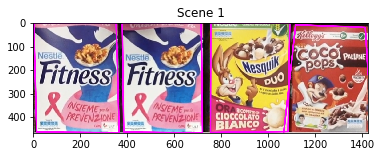

---------------------------------------------------------


----- Analysis of scene m2 -----
Product 0 - 1 instances found:
	Instance 1 [position (178,300), width 343px, height 448px]
Product 1 - 3 instances found:
	Instance 1 [position (511,246), width 303px, height 398px]
	Instance 2 [position (848,258), width 311px, height 410px]
	Instance 3 [position (1178,261), width 302px, height 379px]


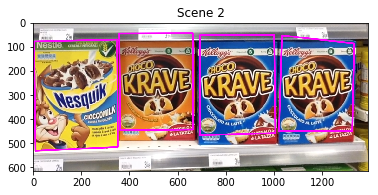

---------------------------------------------------------


----- Analysis of scene m3 -----
Product 19 - 1 instances found:
	Instance 1 [position (1233,190), width 295px, height 381px]
Product 26 - 1 instances found:
	Instance 1 [position (195,229), width 354px, height 459px]
Product 25 - 2 instances found:
	Instance 1 [position (558,226), width 335px, height 453px]
	Instance 2 [position (890,227), width 320px, height 445px]


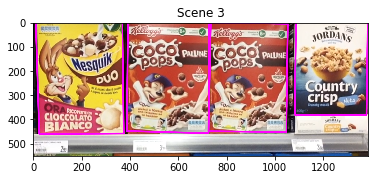

---------------------------------------------------------


----- Analysis of scene m4 -----
Product 24 - 2 instances found:
	Instance 1 [position (540,223), width 348px, height 446px]
	Instance 2 [position (171,223), width 343px, height 446px]
Product 26 - 1 instances found:
	Instance 1 [position (921,221), width 341px, height 442px]
Product 25 - 2 instances found:
	Instance 1 [position (1267,281), width 362px, height 562px]
	Instance 2 [position (1585,267), width 341px, height 534px]


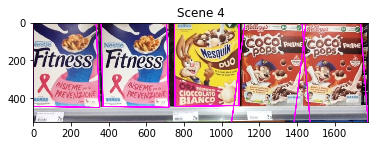

---------------------------------------------------------


----- Analysis of scene m5 -----
Product 1 - 2 instances found:
	Instance 1 [position (500,722), width 313px, height 410px]
	Instance 2 [position (164,712), width 302px, height 396px]
Product 19 - 1 instances found:
	Instance 1 [position (908,191), width 296px, height 382px]
Product 25 - 2 instances found:
	Instance 1 [position (228,273), width 365px, height 547px]
	Instance 2 [position (565,227), width 320px, height 444px]


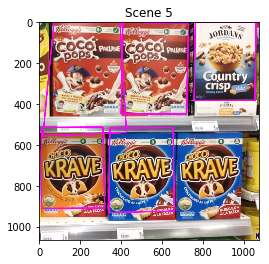

---------------------------------------------------------



In [8]:
# FLANN matcher parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks = 50)

#Thresholds
MIN_MATCH_COUNT = 290
MIN_MATCH_COUNT_SECONDARY = 25
LOWE_RATIO_THRESHOLD = 0.8
DISTANCE_THRESHOLD = 200



# Initiate and set FLANN matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

for scene in range(1, 6): 
   
    print("\n----- Analysis of scene m%d -----" %scene)
    target= cv2.imread('images/scenes/m%d.png' %scene, cv2.IMREAD_COLOR)
    
    # Find keypoints and descriptors with SIFT 
    kp_target, des_target = sift.detectAndCompute(target, None)
    
    barycenters = []
    
    for model, prod_id, kp_model, des_model, model_shape, joinVec in models:
        
        # Match and find the 2 closest elements for each query descriptor
        matches = flann.knnMatch(des_model, des_target, k=2)
        
        #store those matches that are good enougth according to Lowe's ratio test
        good_matches=[m for m, n in matches if m.distance < LOWE_RATIO_THRESHOLD * n.distance]
  
        aa_matches = dict()
        votes=[]
        for match in good_matches:
            
            # Consider keypoints and joining vector related to the considered good match
            source_kp = kp_model[match.queryIdx]
            destination_kp = kp_target[match.trainIdx]
            join = joinVec[match.queryIdx]
            
            # Scale joining vectors
            scale = source_kp.size / destination_kp.size
            join = scale * join
            
            # Hypothesize the posision of the reference point in the scene and store the hp and the corresponding match
            hp = (destination_kp.pt[0] + join[0][0], destination_kp.pt[1] + join[1][0])
            votes.append([hp[0],hp[1]]) 
            if hp in aa_matches.keys():
                aa_matches[hp].append(match)
            else:
                aa_matches[hp] = [match]
           
        # Check if there is al least one vote    
        votes=np.array(votes)
        if(votes.shape[0]==0):
            continue
        
        # Perform cluster
        clusters = performClustering(votes, quantile = 0.9)
       
        instances = []
      
        for cluster in clusters:
    
            instanceMatches = []
           
            # For each point of the cluster pick the matches
            for pt in clusters[cluster]:
                instanceMatches += aa_matches[(pt[0], pt[1])]
            
            # Check if there are enough matches in each cluster
            if len(instanceMatches) < MIN_MATCH_COUNT:
                continue
                
            # Find homography(s)
            src_pts = np.float32([kp_model[m.queryIdx].pt for m in instanceMatches]).reshape(-1,1,2)
            dst_pts = np.float32([kp_target[m.trainIdx].pt for m in instanceMatches]).reshape(-1,1,2)
 
            while True:
                # Find homography
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                if M is None:
                    break
               
                # Corners of the model image
                h,w,d = model_shape
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                
                # Project the corners of the model image into the target image
                dst = cv2.perspectiveTransform(pts,M)
                
                # Set to zero those points falling outside scene image boundaries 
                # after the perspective transformation to better draw boxes partially cut
                for i in dst:
                    i[i<0] = 0
                    
                # Compute barycenter, width and height
                x_corners = [corner[0] for corner in dst[:,0]]
                y_corners = [corner[1] for corner in dst[:,0]]
                barycenter = (sum(x_corners))/4, sum(y_corners) / 4
                width = (x_corners[3] - x_corners[0] + x_corners[2]- x_corners[1]) / 2
                height = (y_corners[1] - y_corners[0] + y_corners[2] - y_corners[3]) / 2
                
                # Check whether two instances are overlapped
                if True in [math.sqrt((barycenter[0] - b[0])**2 + (barycenter[1] - b[1])**2) <= DISTANCE_THRESHOLD for b in barycenters]:
                    #print("Product %d ignored: overlapping" %prod_id)
                    break
                
                # Check wheter the instance found has a rectangular shape
                elif is_rectangle(x_corners, y_corners, height, width) == False:
                    #print("Product %d not a rectangle" %prod_id )
                    break

                else:
                    
                    # Draw the bounding box
                    target = cv2.polylines(target, [np.int32(dst)], True, (255,0,255), 5, cv2.LINE_AA)
                    
                    # Store current barycenter for next tests and the found instance
                    barycenters.append(barycenter)
                    instances.append((barycenter[0], barycenter[1], width, height, len(src_pts)))
                    
                    # Extract points related to the discarded matches to find other instances
                    src_pts = np.float32([pt for i, pt in enumerate(src_pts) if not mask[i][0]])
                    dst_pts = np.float32([pt for i, pt in enumerate(dst_pts) if not mask[i][0]])
                
                    if len(src_pts) < MIN_MATCH_COUNT_SECONDARY:
                        break
                        
        if len(instances) == 0:
            #print("Product %d not found" % prod_id)
            pass
        else:
            print("Product %d - %d instances found:" % (prod_id, len(instances)))
            for index, instance in enumerate(instances):
                p1,p2,w,h,m=instance
                print("\tInstance %d [position (%d,%d), width %dpx, height %dpx]" % (index+1,p1,p2,w,h))
                #print("\tmatches %d" %m)
                
    showImage("Scene %d" % scene, target)
    
    print("---------------------------------------------------------\n")

### Step C (optional) - Whole shelve challenge

#### Try to detect as much products as possible in a challenging scenario

In [9]:
#auxiliar function

def saveModel(productId):
    img2 = cv2.imread('images/models/%d.jpg' % productId, cv2.IMREAD_COLOR)
    # Resize image
    dim=(80,120)
    model = cv2.resize(img2,dim, interpolation = cv2.INTER_AREA)
    # Compute reference point
    ref = (int(model.shape[0] / 2), int(model.shape[1] / 2))
    # Find keipoints and descriptors with SIFT
    kp, des = sift.detectAndCompute(model, None)
    # Compute joining vectors 
    join = [np.array([[ref[0] - point.pt[0]], [ref[1] - point.pt[1]]]) for point in kp]
    return (model, productId, kp, des, model.shape, join)


def is_rectangle(x_corners, y_corners, height, width): 
    # Check if the two diagonals have the same length
    diag1 = math.sqrt(((y_corners[1]-y_corners[0])**2) + ((x_corners[2]-x_corners[1])**2))
    diag2 = math.sqrt(((y_corners[2]-y_corners[3])**2) + ((x_corners[3]-x_corners[0])**2))
    diag_max = max(diag1,diag2)
    diag_min = min(diag1,diag2)
    if diag_max <= 0 or diag_min <= 0 :
        return False
    # Check if it has "resonable" shapes
    elif height > 130 or height < 40 or width > 130 or width < 40: 
        return False
    else:
        return (diag_max/diag_min) <= 3 
    


In [10]:
PRODUCT_IMAGES =  [i for i in range(0,23+1) ] 

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
print("----- Loading models -----" )
# Save models
models = [saveModel(p) for p in PRODUCT_IMAGES]
print("----- Models loaded -----")

----- Loading models -----
----- Models loaded -----



----- Analysis of scene h1 -----
Product 0 - 1 instances found:
	Instance 1 [position (279,310), width 56px, height 72px]
Product 1 - 1 instances found:
	Instance 1 [position (455,313), width 57px, height 72px]
Product 2 - 2 instances found:
	Instance 1 [position (105,108), width 58px, height 90px]
	Instance 2 [position (36,107), width 61px, height 90px]
Product 3 - 1 instances found:
	Instance 1 [position (276,406), width 61px, height 82px]
Product 4 - 2 instances found:
	Instance 1 [position (166,107), width 67px, height 97px]
	Instance 2 [position (229,107), width 69px, height 98px]
Product 5 - 2 instances found:
	Instance 1 [position (370,97), width 42px, height 69px]
	Instance 2 [position (306,96), width 43px, height 68px]
Product 7 - 1 instances found:
	Instance 1 [position (499,115), width 72px, height 122px]


c:\users\chiam\appdata\local\programs\python\python35\lib\site-packages\sklearn\cluster\_mean_shift.py:231: UserWarning: Binning data failed with provided bin_size=0.000003, using data points as seeds.
  " using data points as seeds." % bin_size)
c:\users\chiam\appdata\local\programs\python\python35\lib\site-packages\sklearn\cluster\_mean_shift.py:231: UserWarning: Binning data failed with provided bin_size=30.000000, using data points as seeds.
  " using data points as seeds." % bin_size)


Product 14 - 2 instances found:
	Instance 1 [position (395,398), width 59px, height 85px]
	Instance 2 [position (449,434), width 71px, height 113px]
Product 15 - 1 instances found:
	Instance 1 [position (512,417), width 54px, height 64px]
Product 18 - 1 instances found:
	Instance 1 [position (547,216), width 57px, height 68px]
Product 19 - 1 instances found:
	Instance 1 [position (559,93), width 58px, height 72px]


c:\users\chiam\appdata\local\programs\python\python35\lib\site-packages\sklearn\cluster\_mean_shift.py:231: UserWarning: Binning data failed with provided bin_size=30.000000, using data points as seeds.
  " using data points as seeds." % bin_size)


Product 22 - 2 instances found:
	Instance 1 [position (252,20), width 62px, height 41px]
	Instance 2 [position (317,21), width 62px, height 43px]


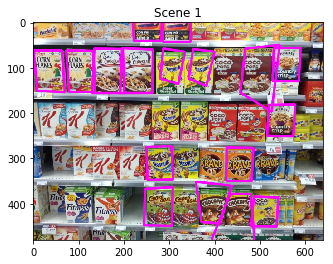

---------------------------------------------------------


----- Analysis of scene h2 -----
Product 0 - 1 instances found:
	Instance 1 [position (311,327), width 55px, height 70px]
Product 1 - 1 instances found:
	Instance 1 [position (368,331), width 54px, height 67px]
Product 2 - 1 instances found:
	Instance 1 [position (84,115), width 52px, height 69px]
Product 3 - 1 instances found:
	Instance 1 [position (364,414), width 49px, height 62px]
Product 4 - 2 instances found:
	Instance 1 [position (205,131), width 66px, height 95px]
	Instance 2 [position (141,129), width 68px, height 94px]


c:\users\chiam\appdata\local\programs\python\python35\lib\site-packages\sklearn\cluster\_mean_shift.py:231: UserWarning: Binning data failed with provided bin_size=30.000000, using data points as seeds.
  " using data points as seeds." % bin_size)


Product 7 - 2 instances found:
	Instance 1 [position (403,137), width 69px, height 120px]
	Instance 2 [position (464,131), width 58px, height 94px]


c:\users\chiam\appdata\local\programs\python\python35\lib\site-packages\sklearn\cluster\_mean_shift.py:231: UserWarning: Binning data failed with provided bin_size=30.000000, using data points as seeds.
  " using data points as seeds." % bin_size)


Product 14 - 1 instances found:
	Instance 1 [position (456,429), width 57px, height 79px]
Product 16 - 1 instances found:
	Instance 1 [position (542,32), width 61px, height 64px]
Product 18 - 1 instances found:
	Instance 1 [position (507,238), width 54px, height 70px]
Product 19 - 1 instances found:
	Instance 1 [position (533,132), width 55px, height 70px]


c:\users\chiam\appdata\local\programs\python\python35\lib\site-packages\sklearn\cluster\_mean_shift.py:231: UserWarning: Binning data failed with provided bin_size=30.000000, using data points as seeds.
  " using data points as seeds." % bin_size)


Product 21 - 1 instances found:
	Instance 1 [position (158,32), width 62px, height 64px]
Product 22 - 2 instances found:
	Instance 1 [position (223,32), width 63px, height 64px]
	Instance 2 [position (289,32), width 62px, height 65px]


c:\users\chiam\appdata\local\programs\python\python35\lib\site-packages\sklearn\cluster\_mean_shift.py:231: UserWarning: Binning data failed with provided bin_size=30.000000, using data points as seeds.
  " using data points as seeds." % bin_size)


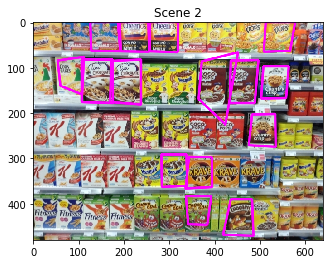

---------------------------------------------------------


----- Analysis of scene h3 -----
Product 0 - 3 instances found:
	Instance 1 [position (346,307), width 52px, height 70px]
	Instance 2 [position (405,285), width 65px, height 118px]
	Instance 3 [position (404,306), width 54px, height 66px]
Product 1 - 1 instances found:
	Instance 1 [position (525,318), width 62px, height 70px]
Product 4 - 2 instances found:
	Instance 1 [position (300,121), width 64px, height 91px]
	Instance 2 [position (243,121), width 62px, height 90px]
Product 5 - 1 instances found:
	Instance 1 [position (362,108), width 48px, height 71px]


c:\users\chiam\appdata\local\programs\python\python35\lib\site-packages\sklearn\cluster\_mean_shift.py:231: UserWarning: Binning data failed with provided bin_size=30.000000, using data points as seeds.
  " using data points as seeds." % bin_size)


Product 7 - 1 instances found:
	Instance 1 [position (576,105), width 79px, height 103px]
Product 14 - 1 instances found:
	Instance 1 [position (555,414), width 57px, height 74px]
Product 15 - 1 instances found:
	Instance 1 [position (616,420), width 57px, height 63px]
Product 16 - 1 instances found:
	Instance 1 [position (583,22), width 67px, height 44px]
Product 18 - 1 instances found:
	Instance 1 [position (611,219), width 58px, height 68px]
Product 19 - 1 instances found:
	Instance 1 [position (643,111), width 66px, height 75px]
Product 21 - 1 instances found:
	Instance 1 [position (260,27), width 59px, height 54px]
Product 22 - 2 instances found:
	Instance 1 [position (384,26), width 61px, height 52px]
	Instance 2 [position (323,27), width 60px, height 54px]


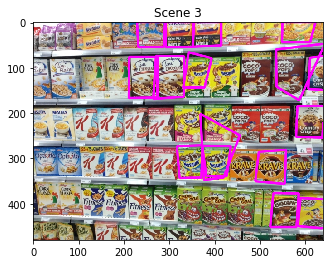

---------------------------------------------------------


----- Analysis of scene h4 -----
Product 0 - 1 instances found:
	Instance 1 [position (327,337), width 58px, height 76px]
Product 1 - 1 instances found:
	Instance 1 [position (448,337), width 58px, height 73px]
Product 2 - 2 instances found:
	Instance 1 [position (84,130), width 63px, height 94px]
	Instance 2 [position (22,129), width 45px, height 92px]
Product 3 - 2 instances found:
	Instance 1 [position (328,442), width 60px, height 85px]
	Instance 2 [position (265,439), width 64px, height 87px]
Product 4 - 2 instances found:
	Instance 1 [position (148,129), width 73px, height 101px]
	Instance 2 [position (216,130), width 70px, height 99px]
Product 5 - 2 instances found:
	Instance 1 [position (353,120), width 46px, height 73px]
	Instance 2 [position (286,119), width 49px, height 74px]
Product 7 - 2 instances found:
	Instance 1 [position (420,129), width 60px, height 99px]
	Instance 2 [position (390,224), width 52px, height 8

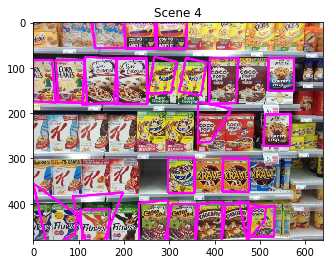

---------------------------------------------------------


----- Analysis of scene h5 -----
Product 0 - 2 instances found:
	Instance 1 [position (282,337), width 56px, height 72px]
	Instance 2 [position (223,339), width 58px, height 74px]
Product 2 - 1 instances found:
	Instance 1 [position (33,128), width 53px, height 80px]
Product 3 - 2 instances found:
	Instance 1 [position (276,447), width 60px, height 82px]
	Instance 2 [position (341,450), width 60px, height 97px]
Product 4 - 2 instances found:
	Instance 1 [position (166,137), width 69px, height 100px]
	Instance 2 [position (100,136), width 68px, height 99px]
Product 5 - 1 instances found:
	Instance 1 [position (238,119), width 42px, height 67px]
Product 7 - 2 instances found:
	Instance 1 [position (368,134), width 61px, height 99px]
	Instance 2 [position (413,237), width 60px, height 74px]
Product 9 - 1 instances found:
	Instance 1 [position (36,341), width 55px, height 74px]
Product 11 - 2 instances found:
	Instance 1 [position

c:\users\chiam\appdata\local\programs\python\python35\lib\site-packages\sklearn\cluster\_mean_shift.py:231: UserWarning: Binning data failed with provided bin_size=30.000000, using data points as seeds.
  " using data points as seeds." % bin_size)


Product 13 - 1 instances found:
	Instance 1 [position (170,428), width 70px, height 87px]
Product 14 - 1 instances found:
	Instance 1 [position (434,433), width 56px, height 80px]
Product 15 - 1 instances found:
	Instance 1 [position (496,437), width 58px, height 64px]
Product 16 - 2 instances found:
	Instance 1 [position (530,32), width 67px, height 64px]
	Instance 2 [position (460,32), width 65px, height 65px]
Product 18 - 1 instances found:
	Instance 1 [position (484,243), width 57px, height 67px]
Product 19 - 1 instances found:
	Instance 1 [position (519,136), width 61px, height 75px]
Product 21 - 1 instances found:
	Instance 1 [position (116,32), width 66px, height 65px]
Product 22 - 2 instances found:
	Instance 1 [position (185,32), width 66px, height 65px]
	Instance 2 [position (252,33), width 67px, height 66px]


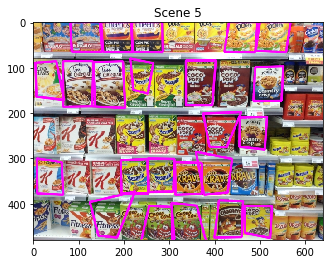

---------------------------------------------------------



In [11]:
# FLANN matcher parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks = 50)

# Thresholds
MIN_MATCH_COUNT = 6 
MIN_MATCH_COUNT_SECONDARY = 5 
LOWE_RATIO_THRESHOLD = 0.8
DISTANCE_THRESHOLD = 15 #10 #5 #7


# Initiate flann matcher 
flann = cv2.FlannBasedMatcher(index_params, search_params)

for scene in range(1, 6): 
    
    print("\n----- Analysis of scene h%d -----" %scene)
    target= cv2.imread('images/scenes/h%d.jpg' %scene, cv2.IMREAD_COLOR)
    
    # Find keypoints and descriptors with SIFT 
    kp_target, des_target = sift.detectAndCompute(target, None)
    
    barycenters = []
    
    for model, prod_id, kp_model, des_model, model_shape, joinVec in models:
        
        # Match and find the 2 closest elements for each query descriptor
        matches = flann.knnMatch(des_model, des_target, k=2)
        
        # Store those matches that are good enougth according to Lowe's ratio test
        good_matches=[m for m, n in matches if m.distance< LOWE_RATIO_THRESHOLD * n.distance]
  
        aa_matches = {}
        votes=[]
        for match in good_matches:
            
             # Consider keypoints and joining vector related to the considered good match
            source_kp = kp_model[match.queryIdx]
            destination_kp = kp_target[match.trainIdx]
            join = joinVec[match.queryIdx]
            
            # Scale joining vectors
            scale = source_kp.size / destination_kp.size
            join = scale * join
            
            # Hypothesize the posision of the reference point in the scene and store the hp and the corresponding match
            hp = (destination_kp.pt[0] + join[0][0], destination_kp.pt[1] + join[1][0])
            votes.append([hp[0],hp[1]]) 
            if hp in aa_matches.keys():
                aa_matches[hp].append(match)
            else:
                aa_matches[hp] = [match]
           
        #Check if there is al least one vote    
        votes=np.array(votes)
        if(votes.shape[0]==0):
            continue
        
        # Perform cluster
        clusters = performClustering(votes)
       
        instances = []
      
        for cluster in clusters:
    
            instanceMatches = []
           
            # For each point of the cluster pick the matches
            for pt in clusters[cluster]:
                instanceMatches += aa_matches[(pt[0], pt[1])]
            
            # Check if there are enough matches in each cluster
            if len(instanceMatches) < MIN_MATCH_COUNT:
                continue
                
            # Find homography(s)
            src_pts = np.float32([kp_model[m.queryIdx].pt for m in instanceMatches]).reshape(-1,1,2)
            dst_pts = np.float32([kp_target[m.trainIdx].pt for m in instanceMatches]).reshape(-1,1,2)
 
            while True:
                # Find homography
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                if M is None:
                    break
               
                # Corners of the model image
                h,w,d = model_shape
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                
                # Project the corners of the model image into the target image
                dst = cv2.perspectiveTransform(pts,M)
                
                # Set to zero those points falling outside scene image boundaries 
                # after the perspective transformation to better draw boxes partially cut
                for i in dst:
                    i[i<0] = 0
                    
                # Compute barycenter, width and height
                x_corners = [corner[0] for corner in dst[:,0]]
                y_corners = [corner[1] for corner in dst[:,0]]
                barycenter = (sum(x_corners))/4, sum(y_corners) / 4
                width = (x_corners[3] - x_corners[0] + x_corners[2]- x_corners[1]) / 2
                height = (y_corners[1] - y_corners[0] + y_corners[2] - y_corners[3]) / 2
                
                # Check whether two instances are overlapped
                if True in [math.sqrt((barycenter[0] - b1[0])**2 + (barycenter[1] - b1[1])**2) <= DISTANCE_THRESHOLD for b1 in barycenters]:
                    #print("Product %d ignored: overlapping" %prod_id)
                    break
                
                # Check wheter the instance found has a rectangular shape
                elif is_rectangle(x_corners,y_corners,height, width) == False:
                    #print("Product %d not a rectangle" %prod_id )
                    break

                else:
                    
                    # Draw the bounding box
                    target = cv2.polylines(target, [np.int32(dst)], True, (255,0,255), 3, cv2.LINE_AA)
                    
                    # Store current barycenter for next tests and the found instance
                    barycenters.append(barycenter)
                    instances.append((barycenter[0], barycenter[1], width, height, len(src_pts)))
                    
                    # Extract points related to the discarded matches to find other instances
                    src_pts = np.float32([pt for i, pt in enumerate(src_pts) if not mask[i][0]])
                    dst_pts = np.float32([pt for i, pt in enumerate(dst_pts) if not mask[i][0]])
                
                    if len(src_pts) < MIN_MATCH_COUNT_SECONDARY:
                        break
                        
        if len(instances) == 0:
            #print("Product %d not found" % prod_id)
            pass
        else:
            print("Product %d - %d instances found:" % (prod_id, len(instances)))
            for index, instance in enumerate(instances):
                p1,p2,w,h,m=instance
                print("\tInstance %d [position (%d,%d), width %dpx, height %dpx]" % (index+1,p1,p2,w,h))
                #print("\tmatches %d" %m)
                
    showImage("Scene %d" % scene, target)
    
    print("---------------------------------------------------------\n")